In [1]:
import torch
import pandas as pd
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
from sklearn.metrics import accuracy_score
from torch import FloatTensor
from torch.utils.data import DataLoader
import numpy as np
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import classification_report
from skimage import io, transform
from torchvision import transforms, utils, datasets
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm_notebook

device = torch.device('cpu')

classes = ('af', 'an', 'di', 'ha',
           'ne', 'sa', 'su')

def get_dataloaders(batch_size):
    df = pd.read_csv(r'/Users/aleksandrcernysov/Desktop/SimpleNN/train_distance.csv', delimiter=',')
    df = df.drop(columns='Unnamed: 0')
    df = df.drop(columns='mood.name')

    df_test = pd.read_csv(r'/Users/aleksandrcernysov/Desktop/SimpleNN/test_distance.csv', delimiter=',')
    df_test = df_test.drop(columns='Unnamed: 0')
    df_test = df_test.drop(columns='mood.name')

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torch.utils.data.TensorDataset(torch.from_numpy(df.iloc[:,0:68].values), torch.from_numpy(df['mood.value'].values))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    testset = torch.utils.data.TensorDataset(torch.from_numpy(df_test.iloc[:,0:68].values), torch.from_numpy(df_test['mood.value'].values))
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [2]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm_notebook(train_dl):
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb.float()), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm_notebook(valid_dl):
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb.float())
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        print(epoch, correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [3]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.fc1 = nn.Linear(68, 120)  # 5x5 image dimension
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 78)
        self.bn2 = nn.BatchNorm1d(78)
        self.fc3 = nn.Linear(78, 84)
        self.fc4 = nn.Linear(84, 78)
        self.dropout = nn.Dropout(p=0.3)
        self.fc5 = nn.Linear(78, 78)
        self.fc6 = nn.Linear(78, 7)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        ind = x
        x = self.fc3(x)
        x = self.dropout(self.fc4(x))
        x += ind
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [12]:
model = Model().to(device)
summary(model, (68,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 120]           8,280
       BatchNorm1d-2                  [-1, 120]             240
            Linear-3                   [-1, 78]           9,438
       BatchNorm1d-4                   [-1, 78]             156
            Linear-5                   [-1, 84]           6,636
            Linear-6                   [-1, 78]           6,630
           Dropout-7                   [-1, 78]               0
            Linear-8                   [-1, 78]           6,162
            Linear-9                    [-1, 7]             553
Total params: 38,095
Trainable params: 38,095
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.15
---------------------------------------------

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.0001)

info = fit(1000, model, criterion, optimizer, *get_dataloaders(16))
plot_trainig(*info)

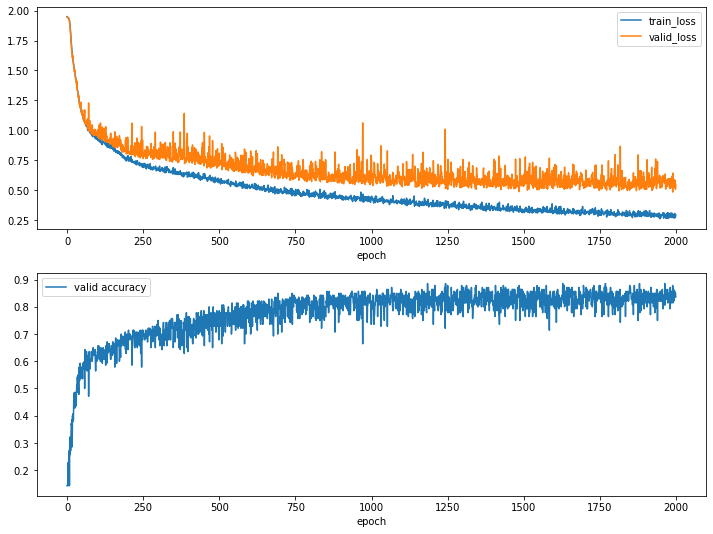

In [144]:
plot_trainig(*info)

In [16]:
def test_model(model):
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))
    _, test_dl = get_dataloaders(4)
    
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            y_pred = model(images.to(device).float())#.view(4, -1))
            _, predicted = torch.max(y_pred, 1)
            c = (predicted.cpu().detach() == labels).squeeze()
            for i in range(c.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(7):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    print(sum(class_correct)/sum(class_total))
    
test_model(model)

Accuracy of    af :  0 %
Accuracy of    an : 95 %
Accuracy of    di : 35 %
Accuracy of    ha : 10 %
Accuracy of    ne : 15 %
Accuracy of    sa : 45 %
Accuracy of    su : 10 %
0.3


In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.fc1 = nn.Linear(68, 120)  # 5x5 image dimension
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 84)
        self.fc4 = nn.Linear(84, 84)
        self.dropout = nn.Dropout(p=0.3)
        self.fc5 = nn.Linear(84, 84)
        self.fc6 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        ind = x
        x = self.fc3(x)
        x = self.dropout(self.fc4(x))
        x = self.fc5(x)
        x += ind
        x = self.fc6(x)
        return x

In [86]:
# Test accuracy 0.797, epochs = 10000, 64, relu, 64
# Test accuracy 0.852, epochs = 10000, 68, relu, 68

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.fc1 = nn.Linear(68, 120)  # 5x5 image dimension
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 78)
        self.fc3 = nn.Linear(78, 84)
        self.fc4 = nn.Linear(84, 78)
        self.dropout = nn.Dropout(p=0.3)
        self.fc5 = nn.Linear(78, 78)
        self.fc6 = nn.Linear(78, 7)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        ind = x
        x = self.fc3(x)
        x = self.dropout(self.fc4(x))
        x += ind
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.fc1 = nn.Linear(68, 120)  # 5x5 image dimension
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 78)
        self.bn2 = nn.BatchNorm1d(78)
        self.fc3 = nn.Linear(78, 84)
        self.fc4 = nn.Linear(84, 78)
        self.dropout = nn.Dropout(p=0.3)
        self.fc5 = nn.Linear(78, 78)
        self.fc6 = nn.Linear(78, 7)

    def forward(self, x):
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        ind = x
        x = self.fc3(x)
        x = self.dropout(self.fc4(x))
        x += ind
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x